# Exercise 6: n-Step Methods

In this exercise we will have a look at n-step methods. This class of reinforcement learning algorithms is an abstraction of the previously discussed Monte-Carlo and TD(0) methods and includes them as special cases. The environment we will be dealing with is a little more typical for control research: the inverted pendulum. 

![](https://miro.medium.com/max/1000/1*TNo3x9zDi1lVOH_3ncG7Aw.gif)

To implement this environment, we will make use of the gym library. Please install the gym library within your preferred Python environment using:

```pip install gym```

In [1]:
import numpy as np
import gym
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

Check if the installation and import work by executing the following cell. A window with an animation of the pendulum should open, display some random actions, and close automatically.

In [2]:
env = gym.make('Pendulum-v0')
env = env.unwrapped # removes a built-in time limit of k_T = 200, we want to determine the time limit ourselves

state = env.reset()
for _ in range(300):
    env.render()
    state, reward, done, _ = env.step(env.action_space.sample()) # take a random action
env.close()

The goal of this environment is to bring the pendulum into the upper neutral position, where the angle $\theta = 0$ and the angular velocitiy $\frac{\text{d}}{\text{d}t}\theta=\omega=0$. The reward function is already designed that way and does not need further specification. For further information about the environment you may refer to the code and documentation of OpenAI's `gym`:

[Documentation of the gym pendulum](https://github.com/openai/gym/wiki/Pendulum-v0)

[Pendulum environment in the gym Github repository](https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py)

## 1) Discretization of Action and State Space

Unlike the racetrack environment, the inverted pendulum comes with a continuous action and state space. Although it is possible to handle systems with these characteristics, we did not yet learn how to deal with them. For now, we only know how to implement agents for discrete action and state spaces. Accordingly, we will also try to represent the inverted pendulum within a discrete state / action space. For this, a discretization is necessary.

The pendulum has three state variables relating to the momentary angular position $\theta$:
\begin{align*}
x=\begin{bmatrix}
\text{cos}(\theta)\\
\text{sin}(\theta)\\
\frac{\text{d}}{\text{d}t}\theta
\end{bmatrix}
\in
\begin{bmatrix}
[-1, 1]\\
[-1, 1]\\
[-8 \, \frac{1}{\text{s}}, 8 \, \frac{1}{\text{s}}]
\end{bmatrix},
\end{align*}

and one input variable which relates to the torque applied at the axis of rotation:

$u = T \in [-2 \, \text{N}\cdot\text{m}, 2 \, \text{N}\cdot\text{m}]$

After the discretization, we want the system to be defined on sets of non-negative natural numbers:

\begin{align*}
x_d=
\text{discretize_state}(x)
\in
\begin{bmatrix}
\{0,1,2,...,d_{\theta}-1\}\\
\{0,1,2,...,d_{\theta}-1\}\\
\{0,1,2,...,d_{\omega}-1\}
\end{bmatrix},
\end{align*}


$
u_d=
\text{discretize_action}(u)
\in
\{0,1,2,...,d_{T}-1\}.
$

Since action is selected within the discrete action space, we need to transform it accordingly:

$
u=
\text{continualize_action}(u_d):
\{0,1,2,...,d_{T}-1\} \rightarrow [-2 \, \text{N}\cdot\text{m}, 2 \, \text{N}\cdot\text{m}]
.
$

Write the functions `discretize_state` and `continualize_action`, such that a discrete RL agent can be applied. (Please note that all I/O of `gym` consists of numpy arrays.) Write the functions in such a way that the number of discretization intervals $d_\theta, d_\omega, d_T$ are parameters that can be changed for different tests. The discretization intervals should be uniformly distributed on their respective state space.

A parametrization of $d_\theta = d_\omega = d_T = 15$ can be used to yield satisfactory results in this exercise.
However, does it make a difference if the number of discretization intervals is odd or even? If yes, what should be preferred for the given environment? 

## Solution 1)

Code given below.

The number of discretization intervals can in fact make a difference in this case. The inverted pendulum can be considered as solved when brought into the upper neutral position $\theta=0, \omega=0$. The state as given by `gym` would therefore be:

$
x_\text{neutral}=
\begin{bmatrix}
\text{cos}(0)\\
\text{sin}(0)\\
0
\end{bmatrix}
=
\begin{bmatrix}
1\\
0\\
0
\end{bmatrix},
u_\text{neutral}=0
$

Consequently, the discretization / continualization should allow for precise transformation of this state, which is given when assuming an odd number of discretization intervals. If one uses an even number of intervals, one interval boundary will be located exactly at zero, potentially leading to rapid bouncing around the neutral position.

In [3]:
d_T = 15
d_theta = 15
d_omega = 15

def discretize_state(states):   
    
    ### BEGIN SOLUTION
    
    limits = [1, 1, 8]
    nb_disc_intervals = [d_theta, d_theta, d_omega]
    
    # bring to value range [-1, 1]
    norm_states = [state / limit for state, limit in zip(states, limits)]
    interval_lengths = [2 / d for d in nb_disc_intervals]
    disc_state = [(norm_state + 1) // interval_length for norm_state, interval_length in zip(norm_states, interval_lengths)]
    disc_state = [(state - 1) if state == d else state for state, d in zip(disc_state, nb_disc_intervals)] # ensure that disc_state < d
    
    return np.array(disc_state)

    ### END SOLUTION
    
    
def continualize_action(disc_action):    
    
    ### BEGIN SOLUTION
    
    limit = 2
    interval_length = 2 / (d_T-1)
    norm_action = disc_action * interval_length
    cont_action = (norm_action - 1) * limit
    return np.array(cont_action).flatten()

    ### END SOLUTION

Use the following cell for debugging:

In [4]:
env = gym.make('Pendulum-v0')
state = env.reset()
for _ in range(5):
    disc_action = np.random.choice(range(9))
    cont_action = continualize_action(disc_action)
    print("discrete action: {}, continuous action: {}".format(disc_action, cont_action))
    
    state, reward, done, _ = env.step(cont_action) # take a random action
    disc_state = discretize_state(state)
    print("discrete state: {}, continuous state: {}".format(disc_state, state))
    
env.close()

discrete action: 7, continuous action: [0.]
discrete state: [1. 2. 7.], continuous state: [-0.78232266 -0.62287338 -0.05880073]
discrete action: 0, continuous action: [-2.]
discrete state: [1. 3. 6.], continuous state: [-0.80737161 -0.59004329 -0.82595577]
discrete action: 3, continuous action: [-1.14285714]
discrete state: [1. 3. 6.], continuous state: [-0.84772402 -0.53043754 -1.43991681]
discrete action: 4, continuous action: [-0.85714286]
discrete state: [0. 4. 5.], continuous state: [-0.8956967  -0.44466552 -1.96631639]
discrete action: 3, continuous action: [-1.14285714]
discrete state: [0. 5. 5.], continuous state: [-0.94367196 -0.33088249 -2.4712441 ]


## Discretization Diagrams

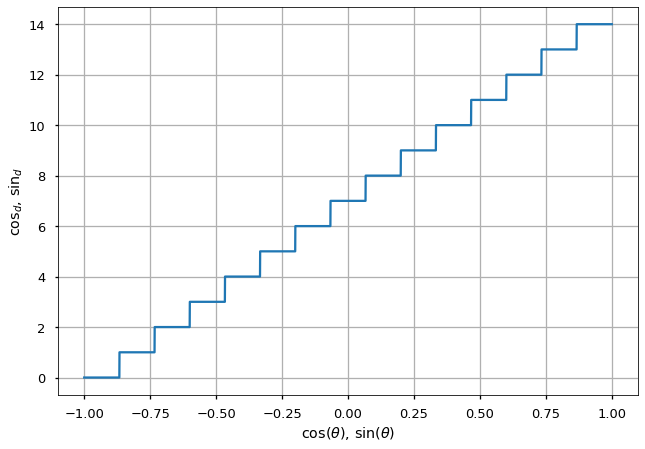

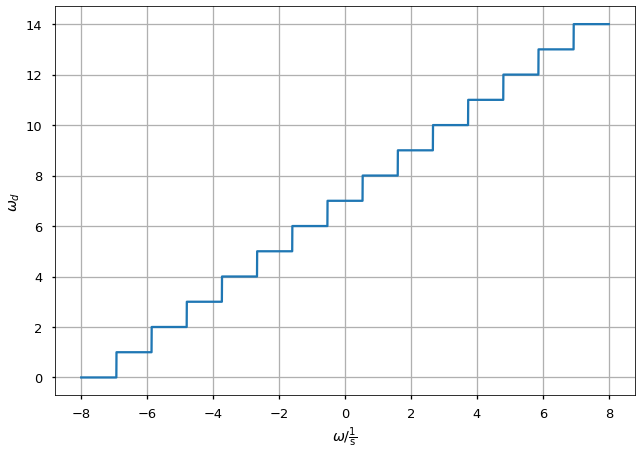

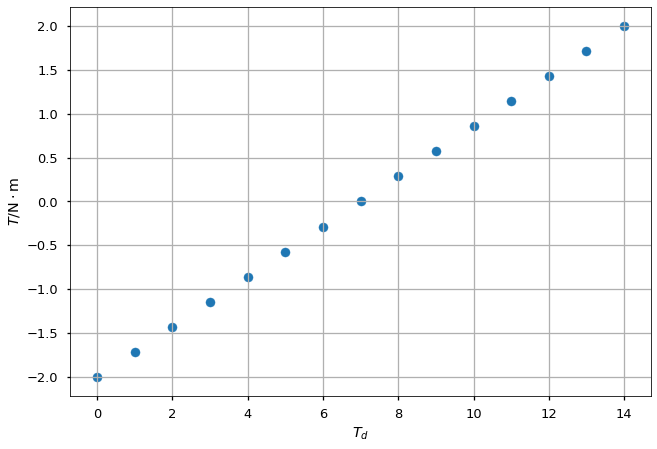

In [5]:
cos_theta = np.linspace(-1, 1, 10000)
sin_theta = np.linspace(-1, 1, 10000)
omega = np.linspace(-8, 8, 10000)
T = np.arange(0, d_T, 1)

disc_states = np.array([discretize_state(np.array([c, s, o])) for c, s, o in zip(cos_theta, sin_theta, omega)])
cont_actions = [continualize_action(np.array(t)) for t in T]

plt.plot(cos_theta, disc_states[:, 0])
plt.xlabel(r"cos$(\theta)$, sin$(\theta)$")
plt.ylabel(r"cos${}_d$, sin${}_d$")
plt.grid()
plt.show()
plt.plot(omega, disc_states[:, 2])
plt.xlabel(r"$\omega / \frac{1}{\mathrm{s}}$")
plt.ylabel(r"$\omega_d$")
plt.grid()
plt.show()
plt.scatter(T, cont_actions)
plt.xlabel(r"$T_d$")
plt.ylabel(r"$T / \mathrm{N} \cdot \mathrm{m}$")
plt.grid()
plt.show()

## 2) n-Step Sarsa

Write an on-policy n-step Sarsa control algorithm for the inverted pendulum from scratch. This time, no code template is given. 

Use the following parameters: $\alpha=0.1, \gamma=0.9, \varepsilon=0.1, n=10$ with 500 time steps in 2000 episodes.

![](nStepSARSA_Algo.png)

## Solution 2)

Execution might take long due to the "render" command, but this allows to observe the learning. Comment out to execute faster.

In [6]:
env = gym.make('Pendulum-v0')
env = env.unwrapped

alpha = 0.1 # learning rate
gamma = 0.9 # discount factor
epsilon = 0.1 # epsilon greedy parameter
n = 10 # steps between updates

nb_episodes = 2000 # number of episodes
nb_steps = 500 # length of episodes

action_values = np.zeros([d_theta, d_theta, d_omega, d_T])
pi = np.zeros([d_theta, d_theta, d_omega])

cumulative_reward_history = [] # we can use this to figure out how well the learning worked

for j in tqdm(range(nb_episodes), position=0, leave=True):
    
    ### BEGIN SOLUTION
    
    states = []
    actions = []
    rewards = []
   
    state = env.reset() # initialize x_0
    done = False
    k_T = None # terminal time (not actually needed for the pendulum, but we want to keep it general)
    
    disc_state = tuple(discretize_state(state).astype(int)) # only tuples of integers can be used as index 
    disc_action = pi[disc_state].astype(int)
    
    states.append(disc_state)
    actions.append(tuple([disc_action]))

    for k in range(nb_steps + n -2):
        
        if not done:
            cont_action = continualize_action(disc_action)
            # env.render() # comment out for faster execution
            state, reward, done, _ = env.step(cont_action)
           
            disc_state = tuple(discretize_state(state).astype(int))

            states.append(disc_state)
            rewards.append(reward)
        
        if not done: # was already checked before step but has to be checked again after step
            if np.random.uniform(0, 1) < epsilon:
                disc_action = np.random.choice(d_T) # explorative action
            else:
                disc_action = pi[disc_state].astype(int) # exploitative action
                
            actions.append(tuple([disc_action]))
            
        elif k_T == None: # if necessary, set terminal time
            k_T = k
            
        tau = k - n + 1 
        
        if tau >= 0: # test if agent waited long enough to learn
            
            if not done:
                idx_range = np.arange(tau + 1, tau + n + 1) # (first entry is inclusive, second is exclusive)
                n_rewards = rewards[tau : tau + n] # at k+1 there are only k entries in rewards
            else:
                idx_range = np.arange(tau + 1, k_T)
                n_rewards = rewards[tau : k_T - 1]
                
            g = np.sum([gamma ** (i-tau-1) * r for i, r in zip(idx_range, n_rewards)])
            
            if not done:     
                g += gamma ** n * action_values[states[tau + n]][actions[tau + n]]
                
            action_values[states[tau]][actions[tau]] += alpha * (g - action_values[states[tau]][actions[tau]])
            pi[states[tau]] = np.argmax(action_values[states[tau]])
            
        if tau + 1 == k_T:
            break
            
    cumulative_reward_history.append(np.sum(rewards))
            
env.close()

pi_learned = np.copy(pi) # save pi in cache under different name for later

### END SOLUTION

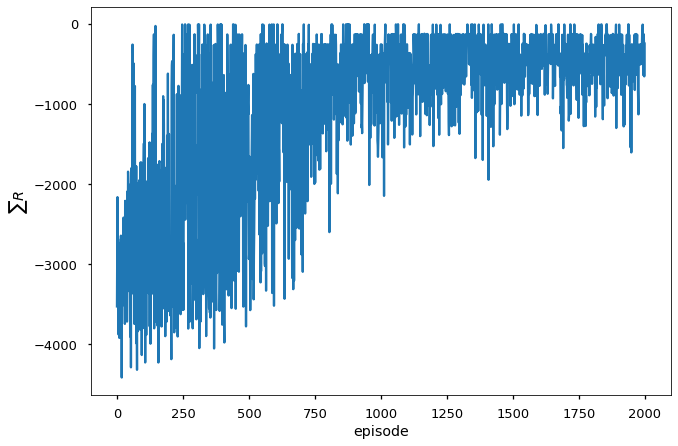

(2000,)


In [7]:
plt.plot(cumulative_reward_history)
plt.xlabel("episode")
plt.ylabel(r"$\sum R$")
plt.show()

print(np.shape(cumulative_reward_history))

## Greedy Execution

Test the learned policy by pure greedy execution.

In [9]:
env = gym.make('Pendulum-v0')
env = env.unwrapped

nb_steps = 200

state = env.reset() # initialize x_0
disc_state = tuple(discretize_state(state).astype(int)) # only tuples of integers can be used as index 
disc_action = pi_learned[disc_state].astype(int)

for k in range(nb_steps):
        
    cont_action = continualize_action(disc_action)
    env.render() # comment out for faster execution
    state, reward, done, _ = env.step(cont_action)
    disc_state = tuple(discretize_state(state).astype(int))
        
    if done:
        break
        
    disc_action = pi_learned[disc_state].astype(int) # exploitative action
    
env.close()

## 3) Tree Backups

Although n-step Sarsa is a very powerful algorithm, it still needs to be trained on-policy. This is not a problem in simulations, but it might be quite dangerous if used on physical systems. Therefore, we also need an off-policy solution. 

Use the policy learned in task (2) as a behavior policy when implementing n-step Sarsa with tree backups and compare their learning behavior. Be aware that execution may be time consuming.

Use the following parameters: $\alpha=0.1, \gamma=0.9, \varepsilon=0.1, n=5$ with 500 time steps in 10 000 episodes (might take some time).

What can we say about the training process? What can we say about the resulting learned policy? Did the agent learn a good policy? Why? Why not?

![](nStepTreeBackup_Algo.png)

In [17]:
env = gym.make('Pendulum-v0')
env = env.unwrapped

alpha = 0.1 # learning rate
gamma = 0.9 # discount factor
epsilon = 0.1 # 0.1 # epsilon greedy parameter
n = 5 # steps between updates

nb_episodes = 10000 # number of episodes
nb_steps = 500 # length of episodes

action_values = -999 * np.ones([d_theta, d_theta, d_omega, d_T])
behavior_policy = np.copy(pi_learned) # pi_learned should be the learned policy from (2), make sure it is active
pi = np.zeros([d_theta, d_theta, d_omega])

cumulative_reward_history = [] # we can use this to figure out how well the learning worked

for j in tqdm(range(nb_episodes), position=0, leave=True):
    
    ### BEGIN SOLUTION
    
    states = []
    actions = []
    rewards = []
   
    state = env.reset() # initialize x_0
    done = False
    k_T = None # terminal time (not actually needed for the pendulum, but we want to keep it general)
    
    disc_state = tuple(discretize_state(state).astype(int)) # only tuples of integers can be used as index 
    disc_action = behavior_policy[disc_state].astype(int)
    
    states.append(disc_state)
    actions.append(tuple([disc_action]))

    for k in range(nb_steps + n - 2):
        
        if not done:
            cont_action = continualize_action(disc_action)
            # env.render() # comment out for faster execution
            state, reward, done, _ = env.step(cont_action)
            
           
            disc_state = tuple(discretize_state(state).astype(int))

            states.append(disc_state)
            rewards.append(reward)
        
        if not done: # was already checked before step but has to be checked again after step
            if np.random.uniform(0, 1) < epsilon:
                disc_action = np.random.choice(d_T) # explorative action
            else:
                disc_action = behavior_policy[disc_state].astype(int) # exploitative action
                
            actions.append(tuple([disc_action]))
            
        elif k_T == None: # if necessary, set terminal time
            k_T = k + 1
            
        tau = k - n + 1 
        
        if tau >= 0: # test if agent waited long enough to learn
            
            if not done:
                sum_pi_q = np.max(action_values[states[k+1]])
                g = rewards[k] + gamma * sum_pi_q # at time = k+1, there are k entries in rewards, so [k] is the last one
            else:
                g = rewards[k_T - 1]
            
            if not k_T == None:
                i_idx_start = np.min([k, k_T - 1])
            else:
                i_idx_start = k
                               
            i_idx_range = np.arange(i_idx_start, tau, -1) # second entry is exclusive, go backwards in time
            
            for i in i_idx_range:
                # 1st entry in states belongs to 0th entry in rewards, 
                # hence states[i] belongs to rewards[i-1]
                
                # expected action_value of actions that were NOT applied + expected return of action that was applied
                if actions[i] == pi[states[i]]:
                    sum_pi_qg = g
                else:
                    sum_pi_qg = np.max(action_values[states[i]])
                    
                g = rewards[i-1] + gamma * sum_pi_qg
                
                
            action_values[states[tau]][actions[tau]] += alpha * (g - action_values[states[tau]][actions[tau]])
            pi[states[tau]] = np.argmax(action_values[states[tau]])
            
        if tau + 1 == k_T:
            break
            
    cumulative_reward_history.append(np.sum(rewards))
            
env.close()

### END SOLUTION

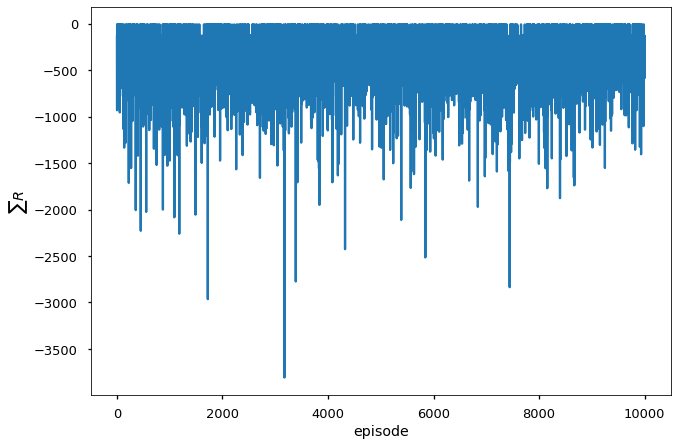

(10000,)


In [18]:
plt.plot(cumulative_reward_history)
plt.xlabel("episode")
plt.ylabel(r"$\sum R$")
plt.show()

print(np.shape(cumulative_reward_history))

## Greedy Execution

Test the learned policy by pure greedy execution.

In [24]:
env = gym.make('Pendulum-v0')
env = env.unwrapped

nb_steps = 200


state = env.reset() # initialize x_0
disc_state = tuple(discretize_state(state).astype(int)) # only tuples of integers can be used as index 
disc_action = pi[disc_state].astype(int)

for k in range(nb_steps):
        
    cont_action = continualize_action(disc_action)
    env.render() # comment out for faster execution
    state, reward, done, _ = env.step(cont_action)
    disc_state = tuple(discretize_state(state).astype(int))
        
    if done:
        break
        
    disc_action = pi[disc_state].astype(int) # exploitative action
    
env.close()

## 4) Comprehensive: n-Step $Q(\sigma)$ Hyperparameter Optimization

The $Q(\sigma)$ algorithm allows for even more flexibility. Like in n-step Sarsa, we can again choose the number $n$ of past steps to consider for an update. Moreover, we can choose the parameter $\sigma$ to change the weighting between sampled and expected state transitions. Accordingly, a properly tuned $Q(\sigma)$ agent is very flexible and thus powerful.

Unfortunately, with great power comes great responsibility. Namely, the responsibility to make a good decision on the parameters. What is a "properly tuned" agent? This is a very basic question of RL and now we want to investigate it by the means of a (small) hyperparameter optimization that utilizes simple grid search.

Write an off-policy epsilon-greedy $Q(\sigma)$ ($\pi$ greedy and $b$ $\varepsilon$-greedy) algorithm to control the inverted pendulum. The algorithm should be formulated as a function, such that we can pass $n$ and $\sigma$ to it and get a policy and a reward history returned. For simplicity, we define $\sigma=\text{const.}$ during one training process.

Carry out the training process for $n \in \{0,2,4,...,10\}$ and for $\sigma \in \{0,0.2,0.4,...,1\}$. Evaluate the training process by determining the best reward history (how can we define what is a good reward history?).

Parameters: $\alpha=0.1, \gamma=0.9, \varepsilon=0.1$ with 500 time steps in 2 000 episodes

![](QSigma_1.png)
![](QSigma_2.png)

## Solution 4)

This task will take some time both, in coding and in running the optimization.

In [14]:
def Q_sigma(n, sigma):
    env = gym.make('Pendulum-v0')
    env = env.unwrapped
    
    action_values = np.zeros([d_theta, d_theta, d_omega, d_T])
    pi = np.zeros([d_theta, d_theta, d_omega]) # on policy: b=pi
    
    alpha = 0.1
    gamma = 0.9
    epsilon = 0.1
    # sigma is an argument of this function
    nb_steps = 500
    nb_episodes = 2000
    
    reward_history = []
    
    for j in tqdm(range(nb_episodes), position=0, leave=True):
        
        ### BEGIN SOLUTION
        
        states = []
        actions = []
        rewards = []
        rhos = []
        
        state = env.reset()
        state = tuple(discretize_state(state).astype(int))
        
        action = pi[state].astype(int)
                      
        states.append(state)
        actions.append(action)
        
        done = False
        k_T = None
        
        for k in range(nb_steps + n - 2):
            
            if not done:
                action = continualize_action(action)
                state, reward, done, _= env.step(action)
                state = tuple(discretize_state(state).astype(int))

                states.append(state)
                rewards.append(reward)
            
            if not done:
                if epsilon > np.random.uniform(0, 1):
                    action = np.random.choice(d_T)
                    rho = 0
                else:
                    action = pi[state].astype(int)
                    rho = 1 / (1 - epsilon + epsilon / d_T)
                    
                actions.append(action)
                rhos.append(rho)
                
            elif k_T == None:
                k_T = k + 1
            
            tau = k - n + 1
            
            if tau >= 0:
                g = 0
                
                if not k_T == None:
                    i_idx_start = np.min([k, k_T - 1])
                else:
                    i_idx_start = k
                i_idx_range = np.arange(i_idx_start, tau, -1)
                
                for i in i_idx_range:
                    if not done:
                        v_mean = np.max(action_values[states[i]])
                                        
                        if actions[i] == pi[states[i]]:
                            sigma_sum = sigma * rhos[i-1] + (1-sigma) * 1
                        else:
                            sigma_sum = sigma * rhos[i-1]
                          
                        g = rewards[i-1] + gamma * (sigma_sum * (g - action_values[states[i]][actions[i]]) + v_mean)
                        
                    elif i == k_T-1:
                        g = rewards[i-1]
                    
                action_values[states[tau]][actions[tau]] += alpha * (g - action_values[states[tau]][actions[tau]])
                pi[states[tau]] = np.argmax(action_values[states[tau]])
                
        reward_history.append(np.sum(rewards))
                    
    return pi, reward_history

### END SOLUTION

In [15]:
n_step = 2
sigma_step = 0.2
ns = np.arange(0, 10 + n_step, n_step)
sigmas = np.arange(0, 1 + sigma_step, sigma_step)

### BEGIN SOLUTION

performances = np.zeros([len(ns), len(sigmas)])

for n_idx, n in enumerate(ns):
    for sig_idx, sigma in enumerate(sigmas):
        pi, reward_history = Q_sigma(n=n, sigma=sigma)
        perf = np.sum(reward_history)
        performances[n_idx, sig_idx] = perf
        
### END SOLUTION

In [48]:
for row in range(len(performances[:, 0])):
    for column in range(len(performances[0, :])):
        print("{:.2f}  ".format(performances[row, column]), end="")
    print()

-7313178.13  -7363694.51  -7359180.83  -7322562.99  -7325828.38  -7354237.44  
-6415744.56  -6287707.23  -6265669.10  -6280096.38  -6189185.91  -6178951.64  
-6399038.48  -6498363.17  -6447845.46  -6729841.81  -6646616.90  -6694048.96  
-5465726.84  -5608451.25  -5814974.75  -6031676.45  -6007150.16  -6176443.91  
-3963245.43  -4290787.98  -4898146.01  -5140961.97  -5483405.39  -5672169.08  
-2999134.95  -3234438.23  -3693062.02  -3973789.17  -4799713.46  -5156560.95  


In [41]:
pi, reward_history = Q_sigma(n=10, sigma=0)
perf = np.sum(reward_history)

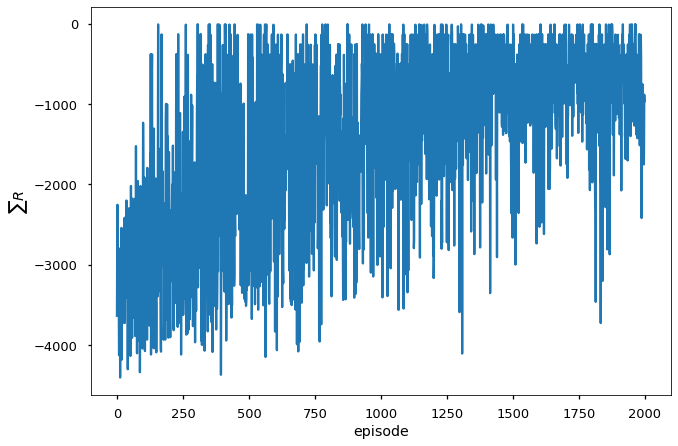

(2000,)


In [42]:
plt.plot(reward_history)
plt.xlabel("episode")
plt.ylabel(r"$\sum R$")
plt.show()

print(np.shape(reward_history))

In [55]:
env = gym.make('Pendulum-v0')
env = env.unwrapped

nb_steps = 500


state = env.reset() # initialize x_0
disc_state = tuple(discretize_state(state).astype(int)) # only tuples of integers can be used as index 
disc_action = pi[disc_state].astype(int)

for k in range(nb_steps):
        
    cont_action = continualize_action(disc_action)
    env.render() # comment out for faster execution
    state, reward, done, _ = env.step(cont_action)
    disc_state = tuple(discretize_state(state).astype(int))
        
    if done:
        break
        
    disc_action = pi[disc_state].astype(int) # exploitative action
    
env.close()